# A simple example on doing Membership Inference Attacks with TensorFlow Privacy

This code is tested to work with:
- Python 3.7
- TensorFlow 2.7
- TensorFlow Privacy 0.7.3



In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# tensorflow imports
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

2024-06-03 14:20:45.585638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# install the most recent verson of tensorflow-privacy
#!pip install -U git+https://github.com/tensorflow/privacy


In [3]:
# tensorflow-privacy 
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec

## Some helper methods

In [4]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  # if we don't specify an activation for the last layer, we can have the logits
  x = Dense(10)(x)
  model = Model(i, x)
  return model

In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10()

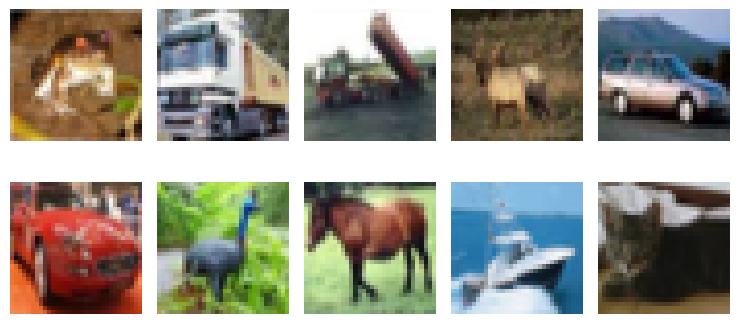

In [6]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i])

plt.tight_layout()
plt.show()

In [7]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [8]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training
Train the model for 30 epochs. 

The idea is that we can use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk respectively. 


In [9]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=30)

Epoch 1/30
391/391 [==============================] - 20s 49ms/step - loss: 1.6888 - accuracy: 0.3818 - val_loss: 1.4573 - val_accuracy: 0.4631
Epoch 2/30
391/391 [==============================] - 19s 49ms/step - loss: 1.3421 - accuracy: 0.5157 - val_loss: 1.2439 - val_accuracy: 0.5532
Epoch 3/30
391/391 [==============================] - 20s 50ms/step - loss: 1.1847 - accuracy: 0.5816 - val_loss: 1.1147 - val_accuracy: 0.6042
Epoch 4/30
391/391 [==============================] - 20s 51ms/step - loss: 1.0840 - accuracy: 0.6181 - val_loss: 1.0810 - val_accuracy: 0.6205
Epoch 5/30
391/391 [==============================] - 21s 54ms/step - loss: 1.0019 - accuracy: 0.6505 - val_loss: 1.0412 - val_accuracy: 0.6434
Epoch 6/30
391/391 [==============================] - 22s 57ms/step - loss: 0.9389 - accuracy: 0.6725 - val_loss: 1.0774 - val_accuracy: 0.6400
Epoch 7/30
391/391 [==============================] - 21s 55ms/step - loss: 0.8876 - accuracy: 0.6900 - val_loss: 0.9367 - val_accuracy:

(0.0, 1.0)

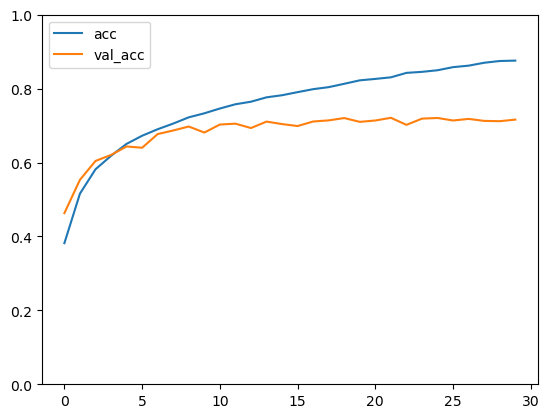

In [10]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

### Attack on the model

In [11]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = tf.nn.softmax(logits_train, axis=-1)
prob_test = tf.nn.softmax(logits_test)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
1563/1563 [==============================] - 17s 11ms/step
Predict on test...
313/313 [==============================] - 3s 10ms/step
Apply softmax to get probabilities from logits...
Compute losses...


In [12]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [13]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [14]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [15]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

/opt/anaconda3/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/opt/anaconda3/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/opt/anaconda3/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/opt/anaconda3/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/opt/anaconda3/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower

In [16]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 5114 training and 2839 test examples) achieved an AUC of 0.72 on slice CORRECTLY_CLASSIFIED=False
  THRESHOLD_ATTACK (with 5114 training and 2839 test examples) achieved an advantage of 0.34 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 5000 training and 1000 test examples) achieved a positive predictive value of 1.00 on slice CLASS=0
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved top-5 epsilon lower bounds of 5.0580, 5.0494, 5.0407, 5.0320, 5.0232 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.59
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved an advantage of 0.19
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved a positive predictive value of 0.86
  LOGISTIC_REGRESSION (with 50000 training and 10000 

Figure(640x480)
attacks_result.get_result_with_max_auc():  SingleAttackResult(
  SliceSpec: CORRECTLY_CLASSIFIED=False
  DataSize: (ntrain=5114, ntest=2839)
  AttackType: LOGISTIC_REGRESSION
  AUC: 0.72
  Attacker advantage: 0.34
  Positive Predictive Value: 0.90
  Epsilon lower bound: 3.5224, 3.5079, 3.4933, 3.4914, 3.4784
)
attacks_result.get_result_with_max_auc().roc_curve:  RocCurve(
  AUC: 0.72
  Attacker advantage: 0.34
  Positive predictive value: 0.90
)
attacks_result.get_result_with_max_attacker_advantage():  SingleAttackResult(
  SliceSpec: CORRECTLY_CLASSIFIED=False
  DataSize: (ntrain=5114, ntest=2839)
  AttackType: THRESHOLD_ATTACK
  AUC: 0.72
  Attacker advantage: 0.34
  Positive Predictive Value: 1.00
  Epsilon lower bound: 3.7643, 3.7493, 3.7340, 3.7185, 3.7028
)


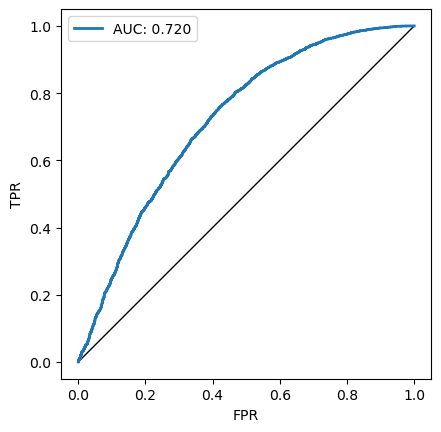

In [30]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

# Print the advantage value
print("attacks_result.get_result_with_max_auc(): ", attacks_result.get_result_with_max_auc())

print("attacks_result.get_result_with_max_auc().roc_curve: ", attacks_result.get_result_with_max_auc().roc_curve)
print("attacks_result.get_result_with_max_attacker_advantage(): ", attacks_result.get_result_with_max_attacker_advantage())